# BO Fingerprint

This notebook investigate the effect of various fingerprints on the performance of the bayesian optimizer. It uses the [default Botorch optimizer](./bo_initialization.ipynb), with a 10 points FPS initialization sequence (default behavior).

[Morgan](https://pubs.acs.org/doi/10.1021/ci100050t): Topological fingerprint

[RDKFingerprint](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.SimilarityMaps.html#rdkit.Chem.Draw.SimilarityMaps.GetRDKFingerprint): Atom path and hash

[EState](https://pubs.acs.org/doi/abs/10.1021/ci00028a014): Topological and electronic fingerprint

[Mordred](https://doi.org/10.1186/s13321-018-0258-y): Many chemical descriptors

[ElectroShape](https://doi.org/10.1007/s10822-010-9374-0): 3D shape and electrostatic descriptor

OneHot: one hot encoding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import SmilesToDescriptors, plot_results
from baybe.parameters import CustomDiscreteParameter
from baybe.searchspace import SearchSpace
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.utils.random import set_random_seed
from baybe.recommenders import (
    BotorchRecommender, FPSRecommender,
    TwoPhaseMetaRecommender, RandomRecommender
)

set_random_seed(11)

#load the dataset, if not available run process_database.py first
df = pd.read_csv("dataset.csv")

reactant_1_pool  = df['reactant_1'].unique()
catalyst_1_pool  = df['catalyst_1'].unique()
catalyst_2_pool  = df['curated_catalyst_2'].unique()


def get_method_searchspace(method_name):
    """
    method_name: str representing the descriptor method to use

    Return the searchspace encode with the proper fingerprints
    """

    # Compute fingerprints for reactants and catalysts
    r_desc  = SmilesToDescriptors(reactant_1_pool, method=method_name)
    c1_desc = SmilesToDescriptors(catalyst_1_pool, method=method_name)
    c2_desc = SmilesToDescriptors(catalyst_2_pool, method=method_name)

    # Build the parameters
    p_r  = CustomDiscreteParameter(name="reactant_1", data=r_desc, decorrelate=0.7)
    p_c1 = CustomDiscreteParameter(name="catalyst_1", data=c1_desc, decorrelate=0.7)
    p_c2 = CustomDiscreteParameter(name="curated_catalyst_2", data=c2_desc, decorrelate=0.7)

    #Define searchspace from parameters
    parameters  = [p_r, p_c1, p_c2]
    searchspace = SearchSpace.from_product(parameters)
    return searchspace

c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#compute the fingerprints, takes around 5 minutes on my laptop (11th Gen i7 @ 2.80 GHz, 16GB RAM)

METHODS = ['Morgan', 'RDK', 'EState', 'OneHot', 'Mordred', 'ElectroShape']

BATCH_SIZE       = 1
N_DOE_ITERATIONS = 100
N_MC_ITERATIONS  = 5

#Use the Botorch recommender with FPS for the first 10 iterations, default behavior
botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),
    recommender=BotorchRecommender(),
    switch_after=10,
)

#random recommender for baseline
random_recommender = RandomRecommender()

lookup = df[['reactant_1', 'catalyst_1', 'curated_catalyst_2', 'ee_R']]

objective = SingleTargetObjective(
    target=NumericalTarget(name='ee_R', mode="MAX")
)

#random campaign defined from any searchspace, should not impact the results
rdm_campaign = Campaign(get_method_searchspace('EState'), objective, random_recommender)

#create the scenario from the campaigns
scenario = {method:Campaign(get_method_searchspace(method), objective, botorch_fps_recommender) for method in METHODS}
scenario['Random'] = rdm_campaign

[16:49:10] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:49:10] UFFTYPER: Unrecognized charge state for atom: 1
[16:49:10] UFFTYPER: Unrecognized hybridization for atom: 16
[16:49:10] UFFTYPER: Unrecognized atom type: Ir (16)
[16:49:19] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:49:19] UFFTYPER: Unrecognized charge state for atom: 1
[16:49:19] UFFTYPER: Unrecognized hybridization for atom: 16
[16:49:19] UFFTYPER: Unrecognized atom type: Ir (16)
[16:53:54] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:53:54] UFFTYPER: Unrecognized charge state for atom: 1
[16:53:54] UFFTYPER: Unrecognized hybridization for atom: 16
[16:53:54] UFFTYPER: Unrecognized atom type: Ir (16)
[16:53:55] UFFTYPER: Unrecognized atom type: Ir2 (0)
[16:53:55] UFFTYPER: Warning: hybridization set to SP3 for atom 1
[16:53:55] UFFTYPER: Unrecognized charge state for atom: 1
[16:53:55] UFFTYPER: Unrecognized atom type: Ir2 (0)
[16:53:55] UFFTYPER: Unrecognized atom type: Ir5 (4)

Notice the warnings coming from ElectroShape, because of catalyst 2, the valance of some atoms and metals are not properly described - may clearly be limiting the performance since this fingreprint strongly rely on geometry.

In [3]:
#simulate the scenarios, takes around 23 minutes on my laptop (11th Gen i7 @ 2.80 GHz, 16GB RAM)

results = simulate_scenarios(
    scenario,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

100%|##########| 35/35 [37:01<00:00, 63.48s/it]


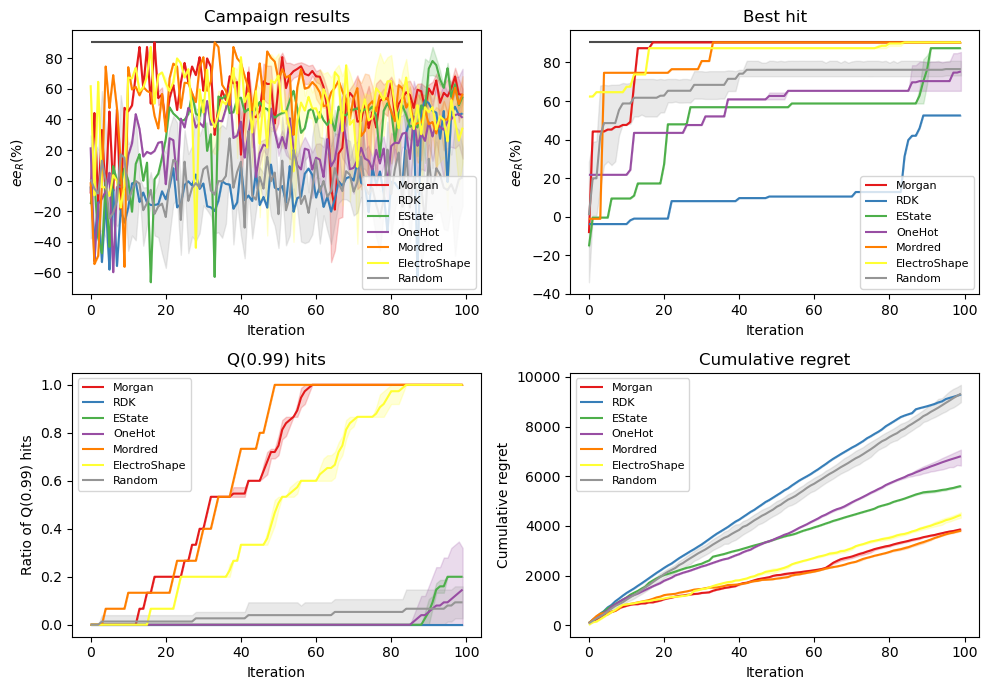

In [4]:
plot_results(results, lookup, figure_name="fingerprints.png", nbr_controls=1)